<a href="https://colab.research.google.com/github/suyeon1109/cornell-lost-ladybug-project/blob/main/data_clear_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train images shape: (1512, 224, 224, 3)
Train labels shape: (1512,)
Test images shape: (391, 224, 224, 3)
Test labels shape: (391,)
0


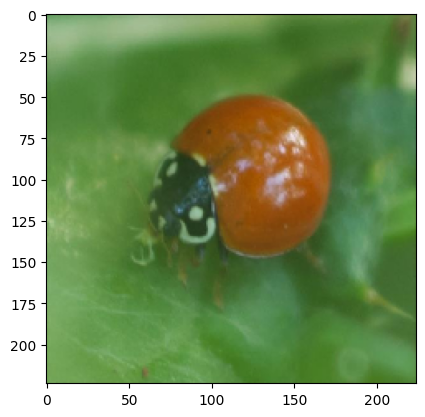

ValueError: ignored

In [3]:
import os
import random
import numpy as np
from keras.preprocessing import image
import keras.utils as image

# Mount Google Drive to access the dataset
# from google.colab import drive
# drive.mount('/content/drive')

# Define the paths to your dataset folders and other parameters
data_dir = '/content/drive/MyDrive/photos'
train_ratio = 0.8
image_size = (224, 224)  # Adjust the image size as needed

# Create a dictionary to map label names to numeric labels
label_mapping = {}
label_counter = 0


# Initialize empty lists to store images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Iterate through each subfolder (label) in the dataset directory
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)

    # Check if the label folder has at least 111 images
    if len(os.listdir(label_dir)) >= 111:
        image_paths = os.listdir(label_dir)

        # If there are more than 112 images, randomly select 112 images
        if len(image_paths) > 112:
            image_paths = random.sample(image_paths, 112)

        # Assign a numeric label and update the mapping
        if label not in label_mapping:
            label_mapping[label] = label_counter
            label_counter += 1

        numeric_label = label_mapping[label]

        # Calculate the number of images for training and testing
        num_train = int(len(image_paths) * train_ratio)

        # Iterate through the selected image paths
        for idx, img_path in enumerate(image_paths):
            img = image.load_img(os.path.join(label_dir, img_path), target_size=image_size)
            img_array = image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize pixel values

            if idx < num_train:
                train_images.append(img_array)
                train_labels.append(numeric_label)
            else:
                test_images.append(img_array)
                test_labels.append(numeric_label)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print the shape of the arrays to verify
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


# (2313, 224, 224, 3)
# 2313: Number of images in the dataset.
# 224: Height of each image in pixels.
# 224: Width of each image in pixels.
# 3: Number of color channels (RGB).

# 샘플 데이터를 matplotlib 이용해서 확인
import matplotlib.pyplot as plt
%matplotlib inline
digit = train_images[5]
print(train_labels[5])
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

# train 데이터
train_images = train_images.reshape((len(train_images), 224*224*3))
train_inages = train_images.astype('float32')

# Assuming 'array_4d' is your 4D array
# new_shape = (train_images.shape[0], -1)  # Keep the first dimension, flatten the rest
# train_images = train_images.reshape(new_shape)

# test 데이터
test_images = test_images.reshape((len(test_images), 224 * 224 * 3)) # 행 10000, 컬럼 28*28
test_images = test_images.astype('float32')

# new_shape = (test_images.shape[0], -1)  # Keep the first dimension, flatten the rest
# test_images = test_images.reshape(new_shape)

# 레이블을 범주형으로 인코딩
from tensorflow.keras.utils import to_categorical


train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM # 이미지는 LSTM, convolution이 일반적!
import tensorflow as tf

tf.random.set_seed(3)

# (1) 모델 설정
# 딥러닝의 구조와 층을 설정하는 단계
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(224*224*3,))) # input_shape로 열, 즉 컬럼 개수가 들어옴
network.add(Dense(26, activation = 'softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy']) # 데이터 레이블이 10개 데이터로 구성됨
                                      # 각 레이블 데이터의 확률이 반환
                                      # 이미지는 adam 대신 rmsprop 사용

# z = network.fit(train_images, train_labels,
#                    batch_size=100,
#                    epochs=10,
#                    verbose=2,
#                    validation_data=(test_images, test_labels))

# (3) 모델 학습 (실행)
network.fit(train_images, train_labels, epochs=1, batch_size=100)

# (4) 모델 평가(결과 출력)
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)
print('test_loss:', test_loss)


#visualize the model working
def predict_test_sample(x):
    label = test_labels[x].argmax(axis=0)
    image = test_images[x].reshape([28,28])
    test_image = test_images[x,:].reshape(1,784)
    prediction = network.predict(test_image).argmax()
    plt.title("Sample %d  Prediction: %d Label: %d" % (x, prediction, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()


for x in range(500):
    image = test_images[x,:].reshape(1,224*224*3)
    prediction = network.predict(image).argmax()
    label = test_labels[x].argmax()
    if (prediction != label):
        plt.title("Sample %d  Prediction: %d Label: %d" % (x, prediction, label))
        plt.imshow(image.reshape([224,224,3]), cmap=plt.get_cmap('gray_r') )
        plt.show()